In [1]:
import sys
import csv
import numpy as np
import pandas as pd 
from collections import Counter
import sklearn,matplotlib
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [2]:
print('python '+sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('sklearn:',sklearn.__version__)
print('matplotlib:',matplotlib.__version__)

python 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.1.5
sklearn: 0.23.2
matplotlib: 3.3.2


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Load case study dataset

In [4]:
in_file = 'car_listing_data.csv'
data = pd.read_csv(in_file,sep=';')
print('Dataset size:\n\t%d rows x %d columns'%(data.shape[0],data.shape[1]))
data = data.dropna()
print('Size after dropping rows with NA records:\n\t%d rows x %d columns'%(data.shape[0],data.shape[1]))
data.head(11)

Dataset size:
	78321 rows x 12 columns
Size after dropping rows with NA records:
	78297 rows x 12 columns


,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
0,350625839,Basic,Mitsubishi,16750,5,2013,24.07.18,24.08.18,3091.0,123.0,30,0.03780329990294403
1,354412280,Basic,Mercedes-Benz,35950,4,2015,16.08.18,07.10.18,3283.0,223.0,52,0.06792567773378008
2,349572992,Basic,Mercedes-Benz,11950,3,1998,16.07.18,05.09.18,3247.0,265.0,51,0.0816137973514013
3,350266763,Basic,Ford,1750,6,2003,20.07.18,29.10.18,1856.0,26.0,101,0.014008620689655173
4,355688985,Basic,Mercedes-Benz,26500,3,2014,28.08.18,08.09.18,490.0,20.0,12,0.04081632653061224
5,361204569,Basic,Volkswagen,24890,6,2017,20.10.18,22.10.18,125.0,6.0,2,0.048
6,362784907,Basic,Fiat,2850,7,2008,08.11.18,09.11.18,172.0,4.0,1,0.022093023255813953
7,363942101,Basic,Renault,23740,2,2018,20.11.18,15.02.19,1499.0,99.0,87,0.06274182788525684
8,358875204,Basic,Renault,7850,6,2016,24.09.18,08.12.18,4329.0,133.0,75,0.030723030723030724
9,357547566,Basic,Mazda,13950,3,2016,08.09.18,10.10.18,2257.0,89.0,32,0.03943287549844927


# <font color='blue'>Data preprocessing</font> 

### A. Split date feature columns each into 3 columns for day, month, and year


In [5]:
data["created_date"] = pd.to_datetime(data["created_date"])
data["deleted_date"] = pd.to_datetime(data["deleted_date"])

data["created_day"] = data['created_date'].map(lambda x: x.day)
data["created_month"] = data['created_date'].map(lambda x: x.month)
data["created_year"] = data['created_date'].map(lambda x: x.year)

print('Distinct created days =',list(Counter(data["created_day"]).keys()))
print('Distinct created months =',list(Counter(data["created_month"]).keys()))
print('Distinct created years =',list(Counter(data["created_year"]).keys()))


data["deleted_day"] = data['deleted_date'].map(lambda x: x.day)
data["deleted_month"] = data['deleted_date'].map(lambda x: x.month)
data["deleted_year"] = data['deleted_date'].map(lambda x: x.year)

#number of distinct days, months, and years
print('Distinct deleted days =',list(Counter(data["deleted_day"]).keys()))
print('Distinct deleted months =',list(Counter(data["deleted_month"]).keys()))
print('Distinct deleted years =',list(Counter(data["deleted_year"]).keys()))


Distinct created days = [24, 16, 20, 28, 11, 9, 7, 8, 10]
Distinct created months = [7, 8, 10, 11, 9, 4, 12]
Distinct created years = [2018]
Distinct deleted days = [24, 10, 9, 29, 22, 11, 15, 12, 19, 28, 8, 31, 17, 27, 26, 21, 1, 23, 13, 25, 18, 16, 20, 30, 14, 2, 3, 7, 4]
Distinct deleted months = [8, 7, 5, 10, 9, 2, 11, 1, 3, 12, 4, 6]
Distinct deleted years = [2018, 2019]


### D. Encode product manufacturer label name (make_name) to manufacturer id


In [6]:
data["make_name"] = data["make_name"].astype('category')
le = preprocessing.LabelEncoder()
le.fit(data['make_name'])
data['make_id'] = le.transform(data['make_name'])
data[["make_name", "make_id"]].head(11)
#print('Before encoding -> make_name catergories:',Counter(data['make_name']))
#print('After enconding -> make_name_enc catergories:',Counter(data['make_name_enc']))

,make_name,make_id
0,Mitsubishi,62
1,Mercedes-Benz,60
2,Mercedes-Benz,60
3,Ford,33
4,Mercedes-Benz,60
5,Volkswagen,88
6,Fiat,32
7,Renault,73
8,Renault,73
9,Mazda,58


### E. Conver CTR feature to float

When trying to convert ctr column values to float, I got the error message (copied below).

`data["ctr"] = data["ctr"].astype('float64')`

<font color='red'>ValueError:</font> could not convert string to float: '27.624.309.392.265.100'


I worked around this by recomputing the Click Through Rate based on the description provided in Data_Description.csv

In [7]:
#Click through rate calculated as the quotient of detail_views over search_views
data["ctr_new"] = data["detail_views"]/data["search_views"]
data[["ctr", "ctr_new"]].head(11)

,ctr,ctr_new
0,0.03780329990294403,0.039793
1,0.06792567773378008,0.067926
2,0.0816137973514013,0.081614
3,0.014008620689655173,0.014009
4,0.04081632653061224,0.040816
5,0.048,0.048000
6,0.022093023255813953,0.023256
7,0.06274182788525684,0.066044
8,0.030723030723030724,0.030723
9,0.03943287549844927,0.039433


### F. Scale price feature values

#### Price column takes a wide range of values, therefore I normalize it by subtracting the mean of the input feature then dividing by the standard deviation.



In [8]:
print('Price feature stats:')
print('\tMin price =',min(data["price"]))
print('\tMax price =',max(data["price"]))
price_mean = np.mean(data["price"])
price_std = np.std(data["price"])
print("\tMean price = %0.2f"%price_mean)
print("\tStandard deviation = %.2f"%price_std)

# Normalize
data["adj_price"] = (data["price"] - price_mean)/price_std
data[["price", "adj_price"]].head(11)

Price feature stats:
	Min price = 50
	Max price = 249888
	Mean price = 15069.67
	Standard deviation = 16375.49


,price,adj_price
0,16750,0.102612
1,35950,1.275096
2,11950,-0.190508
3,1750,-0.813390
4,26500,0.698014
5,24890,0.599697
6,2850,-0.746217
7,23740,0.529470
8,7850,-0.440883
9,13950,-0.068375


### D. Encode product_tier label names to integer ids


#### Product tier is a categorical feature {Basic,Premium, Plus} and can be encoded to Int values {0, 1, 2}. Another option is one-hote-encoding.

In [9]:
le = preprocessing.LabelEncoder()
le.fit(data['product_tier'])
data['product_tier_enc'] = le.transform(data['product_tier'])
print('Before encoding -> product_tier catergories:',Counter(data['product_tier']))
print('After enconding -> product_tier catergories:',Counter(data['product_tier_enc']))
data[["product_tier", "product_tier_enc"]].head(11)

Before encoding -> product_tier catergories: Counter({'Basic': 75397, 'Premium': 2324, 'Plus': 576})
After enconding -> product_tier catergories: Counter({0: 75397, 2: 2324, 1: 576})


,product_tier,product_tier_enc
0,Basic,0
1,Basic,0
2,Basic,0
3,Basic,0
4,Basic,0
5,Basic,0
6,Basic,0
7,Basic,0
8,Basic,0
9,Basic,0


In [10]:
data.dtypes

article_id                          int64
product_tier                       object
make_name                        category
price                               int64
first_zip_digit                     int64
first_registration_year             int64
created_date               datetime64[ns]
deleted_date               datetime64[ns]
search_views                      float64
detail_views                      float64
stock_days                          int64
ctr                                object
created_day                         int64
created_month                       int64
created_year                        int64
deleted_day                         int64
deleted_month                       int64
deleted_year                        int64
make_id                             int64
ctr_new                           float64
adj_price                         float64
product_tier_enc                    int64
dtype: object

# <font color='blue'>Preparing training and test data</font>

In [11]:
# Initialize feature list
feature_list = ['search_views','stock_days','product_tier_enc','deleted_year','first_registration_year','ctr_new',\
'make_id','deleted_day','deleted_month','adj_price','created_month','first_zip_digit','created_day']
#feature_list = ['search_views','stock_days','adj_price',"ctr_new"]
no_views = ['detail_views']
# split input data and labels
X = data[feature_list]
print('X size:',X.shape)
y = data[no_views]
print('y size:',y.shape)

X size: (78297, 13)
y size: (78297, 1)


### A. Split case study data into 67% training and 33% test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### B. Feature scoring and selection

In [13]:
## Feature scoring and selection function
def select_features(X_train, y_train, X_test,func='f_regression', k_val='all'):
    
    if func == 'mutual_info':
        fs = SelectKBest(score_func=mutual_info_regression, k=k_val)
    else:
        fs = SelectKBest(score_func=f_regression, k=k_val)
        
    # learn from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

#### B.1 Mutual information feature scoring and selection

                    Feature  Score (Mutual information)
0              search_views                    0.799932
1                stock_days                    0.199478
2          product_tier_enc                    0.023554
3              deleted_year                    0.040603
4   first_registration_year                    0.027168
5                   ctr_new                    0.396200
6                   make_id                    0.035475
7               deleted_day                    0.037412
8             deleted_month                    0.034560
9                 adj_price                    0.016349
10            created_month                    0.006411
11          first_zip_digit                    0.000000
12              created_day                    0.006001


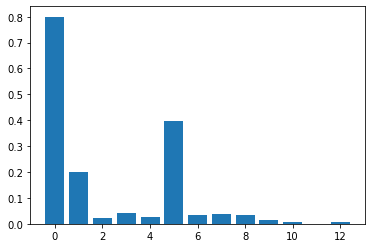

In [14]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='mutual_info')

feature_scores = []
for i in range(len(feature_list)):
    feature_scores.append([feature_list[i],fs.scores_[i]])

df = pd.DataFrame(feature_scores)
df.columns = ['Feature', 'Score (Mutual information)']
print(df)

# plot the scores
pyplot.bar([i for i in range(len(feature_list))], fs.scores_)
pyplot.show()

#### B.2 Correlation feature scoring and selection

In [15]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='f_regression')
feature_scores = []
for i in range(len(feature_list)):
    feature_scores.append([feature_list[i],fs.scores_[i]])

df = pd.DataFrame(feature_scores)
df.columns = ['Feature', 'Score (Correlation)']
df

,Feature,Score (Correlation)
0,search_views,119358.803594
1,stock_days,5294.348169
2,product_tier_enc,3743.329359
3,deleted_year,1921.062879
4,first_registration_year,919.482961
5,ctr_new,672.500541
6,make_id,258.472664
7,deleted_day,124.059764
8,deleted_month,112.199881
9,adj_price,53.116052


In [16]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(data[['detail_views','search_views','ctr_new','stock_days']],
#     alpha=0.3, figsize=(10,10))

# <font color='blue'>Fit Linear Regression Model</font>

### A. Using all features

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)

yhat = model.predict(X_test)
mae = mean_absolute_error(y_test, yhat)
# Mean Absolute Error
print('Mean Absolute Error (MAE): %.3f' % mae)
# Mean squared error
print('Mean Squared Error (MSE): %.3f '%mean_squared_error(y_test,yhat))
#print('MSE: %.3f '% np.mean(yhat- y_test)**2)

print('Model score: %.3f'%model.score(X_test, y_test))


Mean Absolute Error (MAE): 38.701
Mean Squared Error (MSE): 18586.834 
Model score: 0.725


#### <font color='red'> Note: </font>model.score returns the coefficient of determination R^2 of the prediction. The best possible score is 1.0

### B. Using top 5 features selected by  mutual information scoring function

In [18]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='mutual_info', k_val=5)

model = LinearRegression()
model.fit(X_train_fs, y_train)

yhat = model.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)
#print('MSE: %.3f'% np.mean(yhat- y_test)**2)
print('MSE: %.3f '%mean_squared_error(y_test,yhat))
print('Model score: %.3f'%model.score(X_test_fs, y_test))

MAE: 38.390
MSE: 18673.152 
Model score: 0.724


### B. Using top 5 features selected by f_regression scoring function

In [19]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='f_regression', k_val=5)


model = LinearRegression()
model.fit(X_train_fs, y_train)

yhat = model.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)
#print('MSE: %.3f '%np.mean(yhat- y_test)**2)
print('MSE: %.3f '%mean_squared_error(y_test,yhat))
print('Model score: %.3f'%model.score(X_test_fs, y_test))

MAE: 44.387
MSE: 19942.129 
Model score: 0.705


#### <font color=red> Note: </font> Linear Regression model does not provide good results, I'd assume the underlying relationship between features is non-linear. Selecting a subset of features did not improve the model's predictions either.

# Gradient Boosting Regressor

### A. All features
#### A.1 Evaluating the model using cross validation

In [20]:
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

## define the model and evaluate based on cross validation
model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -7.901 (0.577)


#### A.2 Fit the model using all training data and evaluate on test data

In [21]:
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print('MSE: %.3f '%mean_squared_error(y_test,yhat))
print('Model score: %.3f'%model.score(X_test, y_test))

#yhat = yhat.reshape(yhat.shape[0],1)
#print('MSE: %.3f'%np.mean(yhat- y_test)**2)

MSE: 4584.854 
Model score: 0.932


### B. Using top 5 features selected by  mutual information scoring function

In [22]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='mutual_info', k_val=5)

model = GradientBoostingRegressor()
model.fit(X_train_fs, y_train)

yhat = model.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MSE: %.3f '%mean_squared_error(y_test,yhat))
print('Model score: %.3f'%model.score(X_test_fs, y_test))

MSE: 4123.251 
Model score: 0.939


### B. Using top 5 features selected by f_regression scoring function

In [23]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,func='f_regression', k_val=5)

model = GradientBoostingRegressor()
model.fit(X_train_fs, y_train)

yhat = model.predict(X_test_fs)
mae = mean_absolute_error(y_test, yhat)
print('MSE: %.3f '%mean_squared_error(y_test,yhat))
print('Model score: %.3f'%model.score(X_test_fs, y_test))

MSE: 19158.693 
Model score: 0.717


#### <font color='green'>Notes:</font> 
* Using mutual_info as a scoring function improves the MSE and the model's accuracy. 
* f_regression scoring function tests for linear regression hence it did not do well even when using a non-linear regression model, i.e., Gradient Boosting.

### Resources:
* https://machinelearningmastery.com/feature-selection-for-regression-data/
* https://scikit-learn.org/
* https://en.wikipedia.org/wiki/Gradient_boosting